In [3]:
import numpy as np
import pandas as pd
from scipy import interpolate
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from dateutil.relativedelta import relativedelta

In [4]:
class SwapValuationEngine:
    """
    A comprehensive class for valuing interest rate swaps with multi-curve discounting,
    incorporating OIS discounting, credit/debit valuation adjustments (CVA/DVA),
    and funding valuation adjustment (FVA).
    """
    
    def __init__(self):
        self.ois_curve = None
        self.libor_curves = {}
        self.valuation_date = None
        self.holiday_calendar = []
    
    def set_valuation_date(self, valuation_date):
        """Set the valuation date for the swap calculations"""
        self.valuation_date = valuation_date
    
    def add_holidays(self, holidays):
        """Add holiday dates to the calendar"""
        self.holiday_calendar.extend(holidays)
    
    def is_business_day(self, date):
        """Check if a date is a business day"""
        if date.weekday() >= 5 or date in self.holiday_calendar:  # 5,6 = Saturday, Sunday
            return False
        return True
    
    def next_business_day(self, date):
        """Get the next business day"""
        next_day = date + timedelta(days=1)
        while not self.is_business_day(next_day):
            next_day += timedelta(days=1)
        return next_day
    
    def build_ois_curve(self, ois_rates):
        """
        Build the OIS discount curve from market rates
        
        Parameters:
        ois_rates: Dict with tenors as keys and rates as values, e.g. {'1W': 0.0123, '1M': 0.0126, ...}
        """
        # Convert tenor strings to actual dates and days from valuation date
        dates = []
        rates = []
        
        for tenor, rate in ois_rates.items():
            date = self._tenor_to_date(tenor)
            days = (date - self.valuation_date).days
            dates.append(days)
            rates.append(rate)
        
        # Sort by date
        sorted_indices = np.argsort(dates)
        dates = [dates[i] for i in sorted_indices]
        rates = [rates[i] for i in sorted_indices]
        
        # Create interpolation function
        self.ois_curve = interpolate.PchipInterpolator(dates, [self._ois_df(r, d/365) for r, d in zip(rates, dates)])
    
    def _ois_df(self, rate, time):
        """Calculate OIS discount factor"""
        return np.exp(-rate * time)
    
    def build_libor_curve(self, tenor, libor_rates):
        """
        Build a LIBOR forward curve for a specific tenor
        
        Parameters:
        tenor: String representing the LIBOR tenor, e.g. '3M', '6M'
        libor_rates: Dict with swap tenors as keys and rates as values, e.g. {'1Y': 0.0150, '2Y': 0.0175, ...}
        """
        # Convert tenor strings to actual dates and days from valuation date
        dates = []
        rates = []
        
        for swap_tenor, rate in libor_rates.items():
            date = self._tenor_to_date(swap_tenor)
            days = (date - self.valuation_date).days
            dates.append(days)
            rates.append(rate)
        
        # Sort by date
        sorted_indices = np.argsort(dates)
        dates = [dates[i] for i in sorted_indices]
        rates = [rates[i] for i in sorted_indices]
        
        # Bootstrap forward rates from swap rates
        fwd_dates = []
        fwd_rates = []
        
        # Simple bootstrapping algorithm
        tenor_days = self._tenor_to_days(tenor)
        current_date = self.valuation_date
        
        while current_date <= self._tenor_to_date(max(libor_rates.keys(), key=lambda x: self._tenor_to_date(x))):
            days_from_val = (current_date - self.valuation_date).days
            
            if days_from_val in dates:
                # We have a direct market rate
                idx = dates.index(days_from_val)
                fwd_dates.append(days_from_val)
                fwd_rates.append(rates[idx])
            else:
                # Interpolate rate
                fwd_dates.append(days_from_val)
                
                # Find closest dates before and after
                before = max([d for d in dates if d <= days_from_val], default=0)
                after = min([d for d in dates if d >= days_from_val], default=dates[-1])
                
                if before == 0:
                    # Extrapolate from start
                    fwd_rates.append(rates[0])
                elif after == dates[-1] and days_from_val > after:
                    # Extrapolate at end
                    fwd_rates.append(rates[-1])
                else:
                    # Interpolate
                    idx_before = dates.index(before)
                    idx_after = dates.index(after)
                    
                    if before == after:
                        fwd_rates.append(rates[idx_before])
                    else:
                        weight = (days_from_val - before) / (after - before)
                        fwd_rates.append(rates[idx_before] * (1 - weight) + rates[idx_after] * weight)
            
            # Move to next period
            current_date = self._add_tenor(current_date, tenor)
        
        # Create interpolation function
        self.libor_curves[tenor] = interpolate.PchipInterpolator(fwd_dates, fwd_rates)
    
    def _tenor_to_date(self, tenor):
        """Convert tenor string to date"""
        if tenor[-1] == 'D':
            return self.valuation_date + timedelta(days=int(tenor[:-1]))
        elif tenor[-1] == 'W':
            return self.valuation_date + timedelta(weeks=int(tenor[:-1]))
        elif tenor[-1] == 'M':
            return self.valuation_date + relativedelta(months=int(tenor[:-1]))
        elif tenor[-1] == 'Y':
            return self.valuation_date + relativedelta(years=int(tenor[:-1]))
    
    def _tenor_to_days(self, tenor):
        """Convert tenor string to approximate days"""
        if tenor[-1] == 'D':
            return int(tenor[:-1])
        elif tenor[-1] == 'W':
            return int(tenor[:-1]) * 7
        elif tenor[-1] == 'M':
            return int(tenor[:-1]) * 30
        elif tenor[-1] == 'Y':
            return int(tenor[:-1]) * 365
    
    def _add_tenor(self, date, tenor):
        """Add tenor to date"""
        if tenor[-1] == 'D':
            new_date = date + timedelta(days=int(tenor[:-1]))
        elif tenor[-1] == 'W':
            new_date = date + timedelta(weeks=int(tenor[:-1]))
        elif tenor[-1] == 'M':
            new_date = date + relativedelta(months=int(tenor[:-1]))
        elif tenor[-1] == 'Y':
            new_date = date + relativedelta(years=int(tenor[:-1]))
            
        # Adjust for business days
        if not self.is_business_day(new_date):
            new_date = self.next_business_day(new_date)
            
        return new_date
    
    def get_discount_factor(self, date):
        """Get discount factor for a specific date"""
        if self.ois_curve is None:
            raise ValueError("OIS curve not built yet")
        
        days = (date - self.valuation_date).days
        return self.ois_curve(days)
    
    def get_forward_rate(self, start_date, end_date, tenor):
        """Get forward rate between two dates for a specific tenor"""
        if tenor not in self.libor_curves:
            raise ValueError(f"LIBOR curve for tenor {tenor} not built yet")
        
        start_days = (start_date - self.valuation_date).days
        end_days = (end_date - self.valuation_date).days
        
        if start_days < 0:
            start_days = 0
            
        period = (end_date - start_date).days / 365.0
        
        if period <= 0:
            return 0
            
        start_df = self.get_discount_factor(start_date)
        end_df = self.get_discount_factor(end_date)
        
        return (start_df / end_df - 1) / period
    
    def value_vanilla_swap(self, notional, fixed_rate, float_tenor, fixed_tenor, 
                          start_date, maturity_date, fixed_leg_frequency, 
                          float_leg_frequency, day_count_convention='30/360'):
        """
        Value a vanilla interest rate swap
        
        Parameters:
        notional: Notional amount
        fixed_rate: Fixed leg rate
        float_tenor: Tenor for the floating rate, e.g. '3M'
        fixed_tenor: Tenor for the fixed rate, e.g. '6M'
        start_date: Start date of the swap
        maturity_date: Maturity date of the swap
        fixed_leg_frequency: Frequency of fixed leg payments, e.g. '6M'
        float_leg_frequency: Frequency of floating leg payments, e.g. '3M'
        day_count_convention: Day count convention, currently supports only '30/360' and 'ACT/365'
        
        Returns:
        Dict with 'fixed_leg_value', 'float_leg_value', and 'swap_value'
        """
        # Check if curves are built
        if self.ois_curve is None:
            raise ValueError("OIS curve not built yet")
            
        if float_tenor not in self.libor_curves:
            raise ValueError(f"LIBOR curve for tenor {float_tenor} not built yet")
        
        # Generate fixed leg payment dates
        fixed_payment_dates = []
        current_date = start_date
        
        while current_date < maturity_date:
            next_date = self._add_tenor(current_date, fixed_leg_frequency)
            if next_date > maturity_date:
                next_date = maturity_date
            fixed_payment_dates.append(next_date)
            current_date = next_date
        
        # Generate floating leg payment dates
        float_payment_dates = []
        current_date = start_date
        
        while current_date < maturity_date:
            next_date = self._add_tenor(current_date, float_leg_frequency)
            if next_date > maturity_date:
                next_date = maturity_date
            float_payment_dates.append(next_date)
            current_date = next_date
        
        # Value fixed leg
        fixed_leg_value = 0
        for i, payment_date in enumerate(fixed_payment_dates):
            if i == 0:
                period_start = start_date
            else:
                period_start = fixed_payment_dates[i-1]
                
            period = self._calculate_period(period_start, payment_date, day_count_convention)
            discount_factor = self.get_discount_factor(payment_date)
            fixed_leg_value += notional * fixed_rate * period * discount_factor
        
        # Value floating leg
        float_leg_value = 0
        for i, payment_date in enumerate(float_payment_dates):
            if i == 0:
                period_start = start_date
            else:
                period_start = float_payment_dates[i-1]
                
            period = self._calculate_period(period_start, payment_date, day_count_convention)
            discount_factor = self.get_discount_factor(payment_date)
            
            if period_start < self.valuation_date:
                # Past fixing, use last known rate
                forward_rate = self.libor_curves[float_tenor](0)
            else:
                # Future fixing, use forward rate
                forward_rate = self.get_forward_rate(period_start, payment_date, float_tenor)
                
            float_leg_value += notional * forward_rate * period * discount_factor
        
        # Calculate swap value
        swap_value = float_leg_value - fixed_leg_value
        
        return {
            'fixed_leg_value': fixed_leg_value,
            'float_leg_value': float_leg_value,
            'swap_value': swap_value
        }
    
    def _calculate_period(self, start_date, end_date, day_count_convention):
        """Calculate period fraction according to day count convention"""
        if day_count_convention == '30/360':
            # 30/360 convention: each month is treated as having 30 days
            y1, m1, d1 = start_date.year, start_date.month, start_date.day
            y2, m2, d2 = end_date.year, end_date.month, end_date.day
            
            # Adjust day values
            if d1 == 31:
                d1 = 30
            if d2 == 31 and d1 >= 30:
                d2 = 30
                
            return ((y2 - y1) * 360 + (m2 - m1) * 30 + (d2 - d1)) / 360
            
        elif day_count_convention == 'ACT/365':
            # Actual/365 convention: actual days divided by 365
            return (end_date - start_date).days / 365.0
            
        else:
            raise ValueError(f"Unsupported day count convention: {day_count_convention}")
    
    def calculate_cva_dva(self, swap_value, counterparty_pd, own_pd, recovery_rate=0.4):
        """
        Calculate Credit Valuation Adjustment (CVA) and Debit Valuation Adjustment (DVA)
        
        Parameters:
        swap_value: Current value of the swap
        counterparty_pd: Counterparty probability of default (annual)
        own_pd: Own probability of default (annual)
        recovery_rate: Recovery rate in case of default
        
        Returns:
        Dict with 'cva' and 'dva' values
        """
        exposure = max(0, swap_value)
        negative_exposure = max(0, -swap_value)
        
        # Simple approximation: assume constant exposure over life of swap
        time_to_maturity = 5.0  # Assumed 5 years for this example
        
        # Calculate CVA: expected loss due to counterparty default
        cva = exposure * (1 - recovery_rate) * (1 - np.exp(-counterparty_pd * time_to_maturity))
        
        # Calculate DVA: expected gain due to own default
        dva = negative_exposure * (1 - recovery_rate) * (1 - np.exp(-own_pd * time_to_maturity))
        
        return {
            'cva': cva,
            'dva': dva
        }
    
    def calculate_fva(self, swap_value, funding_spread, collateral_rate=0.0):
        """
        Calculate Funding Valuation Adjustment (FVA)
        
        Parameters:
        swap_value: Current value of the swap
        funding_spread: Spread over risk-free rate for funding
        collateral_rate: Interest rate earned/paid on collateral
        
        Returns:
        FVA value
        """
        # Simple approximation: assume constant exposure over life of swap
        time_to_maturity = 5.0  # Assumed 5 years for this example
        
        # Calculate FVA
        exposure = max(0, swap_value)
        funding_cost = exposure * funding_spread * time_to_maturity
        
        # Adjust for collateral
        collateral_benefit = exposure * collateral_rate * time_to_maturity
        
        return funding_cost - collateral_benefit

In [8]:
# Example usage
def main():
    # Create valuation engine
    engine = SwapValuationEngine()
    
    # Set valuation date
    valuation_date = datetime(2023, 4, 1)
    engine.set_valuation_date(valuation_date)
    
    # Define holidays (simplified)
    holidays = [datetime(2023, 1, 1), datetime(2023, 4, 7), datetime(2023, 5, 29)]
    engine.add_holidays(holidays)
    
    # Build OIS curve
    ois_rates = {
        '1W': 0.0468, '1M': 0.0472, '3M': 0.0479, '6M': 0.0485,
        '1Y': 0.0480, '2Y': 0.0465, '5Y': 0.0450, '10Y': 0.0445
    }
    engine.build_ois_curve(ois_rates)
    
    # Build 3M LIBOR curve
    libor_3m_rates = {
        '3M': 0.0490, '6M': 0.0493, '1Y': 0.0495, '2Y': 0.0485,
        '5Y': 0.0470, '10Y': 0.0463
    }
    engine.build_libor_curve('3M', libor_3m_rates)
    
    # Define swap terms
    notional = 10000000  # $10M
    fixed_rate = 0.045  # 4.5%
    float_tenor = '3M'  # 3-month LIBOR
    fixed_tenor = '6M'  # 6-month fixed payments
    start_date = valuation_date
    maturity_date = valuation_date + relativedelta(years=5)  # 5-year swap
    fixed_leg_frequency = '6M'
    float_leg_frequency = '3M'
    
    # Value the swap
    swap_result = engine.value_vanilla_swap(
        notional, fixed_rate, float_tenor, fixed_tenor,
        start_date, maturity_date, fixed_leg_frequency, 
        float_leg_frequency
    )
    
    # Calculate valuation adjustments
    counterparty_pd = 0.02  # 2% annual default probability
    own_pd = 0.01  # 1% annual default probability
    adjustments = engine.calculate_cva_dva(
        swap_result['swap_value'], counterparty_pd, own_pd
    )
    
    funding_spread = 0.003  # 30bps funding spread
    fva = engine.calculate_fva(swap_result['swap_value'], funding_spread)
    
    # Calculate total adjusted value
    adjusted_value = swap_result['swap_value'] - adjustments['cva'] + adjustments['dva'] - fva
    
    # Print results
    print("Swap Valuation Results")
    print("-" * 50)
    print(f"Valuation Date: {valuation_date.strftime('%Y-%m-%d')}")
    print(f"Maturity Date: {maturity_date.strftime('%Y-%m-%d')}")
    print(f"Notional: ${notional:,.2f}")
    print(f"Fixed Rate: {fixed_rate:.4%}")
    print(f"Floating Rate: {float_tenor} LIBOR")
    print("-" * 50)
    print(f"Fixed Leg Value: ${swap_result['fixed_leg_value']:,.2f}")
    print(f"Floating Leg Value: ${swap_result['float_leg_value']:,.2f}")
    print(f"Raw Swap Value: ${swap_result['swap_value']:,.2f}")
    print("-" * 50)
    print(f"Credit Valuation Adjustment (CVA): ${adjustments['cva']:,.2f}")
    print(f"Debit Valuation Adjustment (DVA): ${adjustments['dva']:,.2f}")
    print(f"Funding Valuation Adjustment (FVA): ${fva:,.2f}")
    print("-" * 50)
    print(f"Total Adjusted Swap Value: ${adjusted_value:,.2f}")

if __name__ == "__main__":
    main()

Swap Valuation Results
--------------------------------------------------
Valuation Date: 2023-04-01
Maturity Date: 2028-04-01
Notional: $10,000,000.00
Fixed Rate: 4.5000%
Floating Rate: 3M LIBOR
--------------------------------------------------
Fixed Leg Value: $1,987,983.34
Floating Leg Value: $2,014,501.59
Raw Swap Value: $26,518.25
--------------------------------------------------
Credit Valuation Adjustment (CVA): $1,514.13
Debit Valuation Adjustment (DVA): $0.00
Funding Valuation Adjustment (FVA): $397.77
--------------------------------------------------
Total Adjusted Swap Value: $24,606.35


In [6]:
def add_visualization_methods(SwapValuationEngine):
    """
    Extend the SwapValuationEngine class with visualization methods
    """
    
    def plot_curves(self):
        """Plot the discount and forward curves"""
        if self.ois_curve is None:
            raise ValueError("OIS curve not built yet")
        
        # Create date range for x-axis
        max_days = 3650  # 10 years
        days = np.linspace(0, max_days, 100)
        dates = [self.valuation_date + timedelta(days=int(d)) for d in days]
        
        # Calculate discount factors
        discount_factors = [self.ois_curve(d) for d in days]
        
        # Create figure
        fig, axes = plt.subplots(2, 1, figsize=(12, 10))
        
        # Plot discount factors
        axes[0].plot(dates, discount_factors, 'b-', label='OIS Discount Factors')
        axes[0].set_title('Discount Curve')
        axes[0].set_ylabel('Discount Factor')
        axes[0].grid(True)
        axes[0].legend()
        
        # Format x-axis with dates
        axes[0].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
        plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45)
        
        # Plot forward rates
        for tenor, curve in self.libor_curves.items():
            forward_rates = [curve(d) for d in days]
            axes[1].plot(dates, forward_rates, label=f'{tenor} Forward Rates')
        
        axes[1].set_title('Forward Curves')
        axes[1].set_ylabel('Rate (%)')
        axes[1].grid(True)
        axes[1].legend()
        
        # Format x-axis with dates
        axes[1].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
        plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)
        
        # Format y-axis as percentage
        axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2%}'))
        
        plt.tight_layout()
        return fig
    
    def plot_swap_cashflows(self, notional, fixed_rate, float_tenor, fixed_tenor, 
                           start_date, maturity_date, fixed_leg_frequency, 
                           float_leg_frequency, day_count_convention='30/360'):
        """Visualize swap cashflows over time"""
        
        # Generate fixed leg payment dates
        fixed_payment_dates = []
        current_date = start_date
        
        while current_date < maturity_date:
            next_date = self._add_tenor(current_date, fixed_leg_frequency)
            if next_date > maturity_date:
                next_date = maturity_date
            fixed_payment_dates.append(next_date)
            current_date = next_date
        
        # Generate floating leg payment dates
        float_payment_dates = []
        current_date = start_date
        
        while current_date < maturity_date:
            next_date = self._add_tenor(current_date, float_leg_frequency)
            if next_date > maturity_date:
                next_date = maturity_date
            float_payment_dates.append(next_date)
            current_date = next_date
        
        # Calculate fixed leg cashflows
        fixed_cashflows = []
        for i, payment_date in enumerate(fixed_payment_dates):
            if i == 0:
                period_start = start_date
            else:
                period_start = fixed_payment_dates[i-1]
                
            period = self._calculate_period(period_start, payment_date, day_count_convention)
            fixed_cashflow = -notional * fixed_rate * period  # Negative for fixed rate payer
            fixed_cashflows.append((payment_date, fixed_cashflow))
        
        # Calculate floating leg cashflows (expected)
        float_cashflows = []
        for i, payment_date in enumerate(float_payment_dates):
            if i == 0:
                period_start = start_date
            else:
                period_start = float_payment_dates[i-1]
                
            period = self._calculate_period(period_start, payment_date, day_count_convention)
            
            if period_start < self.valuation_date:
                # Past fixing, use last known rate
                forward_rate = self.libor_curves[float_tenor](0)
            else:
                # Future fixing, use forward rate
                forward_rate = self.get_forward_rate(period_start, payment_date, float_tenor)
                
            float_cashflow = notional * forward_rate * period  # Positive for fixed rate payer
            float_cashflows.append((payment_date, float_cashflow))
        
        # Create net cashflows
        all_dates = sorted(list(set([d for d, _ in fixed_cashflows] + [d for d, _ in float_cashflows])))
        net_cashflows = []
        
        for date in all_dates:
            fixed_cf = next((cf for d, cf in fixed_cashflows if d == date), 0)
            float_cf = next((cf for d, cf in float_cashflows if d == date), 0)
            net_cf = fixed_cf + float_cf
            net_cashflows.append((date, net_cf))
        
        # Create figure
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Extract data for plotting
        fixed_dates = [d for d, _ in fixed_cashflows]
        fixed_values = [cf for _, cf in fixed_cashflows]
        
        float_dates = [d for d, _ in float_cashflows]
        float_values = [cf for _, cf in float_cashflows]
        
        net_dates = [d for d, _ in net_cashflows]
        net_values = [cf for _, cf in net_cashflows]
        
        # Plot bars
        ax.bar(fixed_dates, fixed_values, width=20, label='Fixed Leg', alpha=0.7, color='red')
        ax.bar(float_dates, float_values, width=20, label='Floating Leg', alpha=0.7, color='blue')
        
        # Plot net line
        ax.plot(net_dates, net_values, 'ko-', label='Net Cashflow')
        
        # Format axes
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax.set_title('Swap Cashflows Over Time')
        ax.set_xlabel('Date')
        ax.set_ylabel('Cashflow')
        
        # Format y-axis as currency
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:,.0f}'))
        
        # Format x-axis as dates
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        
        # Add legend
        ax.legend()
        
        plt.tight_layout()
        return fig
    
    def plot_sensitivity_analysis(self, notional, fixed_rate, float_tenor, fixed_tenor, 
                                start_date, maturity_date, fixed_leg_frequency, 
                                float_leg_frequency, day_count_convention='30/360'):
        """Plot sensitivity analysis of swap value to various factors"""
        
        # Base value
        base_value = self.value_vanilla_swap(
            notional, fixed_rate, float_tenor, fixed_tenor,
            start_date, maturity_date, fixed_leg_frequency, 
            float_leg_frequency, day_count_convention
        )['swap_value']
        
        # Sensitivity to parallel shift in OIS curve
        shifts = np.linspace(-0.01, 0.01, 11)  # -100 bps to +100 bps
        ois_values = []
        
        # Store original OIS curve
        original_ois_curve = self.ois_curve
        
        for shift in shifts:
            # Create shifted OIS rates
            ois_rates = {
                '1W': 0.0468 + shift, '1M': 0.0472 + shift, '3M': 0.0479 + shift, 
                '6M': 0.0485 + shift, '1Y': 0.0480 + shift, '2Y': 0.0465 + shift, 
                '5Y': 0.0450 + shift, '10Y': 0.0445 + shift
            }
            
            # Rebuild OIS curve
            self.build_ois_curve(ois_rates)
            
            # Value swap with shifted curve
            value = self.value_vanilla_swap(
                notional, fixed_rate, float_tenor, fixed_tenor,
                start_date, maturity_date, fixed_leg_frequency, 
                float_leg_frequency, day_count_convention
            )['swap_value']
            
            ois_values.append(value)
        
        # Restore original OIS curve
        self.ois_curve = original_ois_curve
        
        # Sensitivity to parallel shift in LIBOR curve
        libor_values = []
        
        # Store original LIBOR curve
        original_libor_curve = self.libor_curves[float_tenor]
        
        for shift in shifts:
            # Create shifted LIBOR rates
            libor_rates = {
                '3M': 0.0490 + shift, '6M': 0.0493 + shift, '1Y': 0.0495 + shift, 
                '2Y': 0.0485 + shift, '5Y': 0.0470 + shift, '10Y': 0.0463 + shift
            }
            
            # Rebuild LIBOR curve
            self.build_libor_curve(float_tenor, libor_rates)
            
            # Value swap with shifted curve
            value = self.value_vanilla_swap(
                notional, fixed_rate, float_tenor, fixed_tenor,
                start_date, maturity_date, fixed_leg_frequency, 
                float_leg_frequency, day_count_convention
            )['swap_value']
            
            libor_values.append(value)
        
        # Restore original LIBOR curve
        self.libor_curves[float_tenor] = original_libor_curve
        
        # Create figure
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot sensitivity curves
        ax.plot(shifts * 10000, ois_values, 'b-', label='OIS Curve Shift')
        ax.plot(shifts * 10000, libor_values, 'r-', label='LIBOR Curve Shift')
        
        # Format axes
        ax.axhline(y=base_value, color='k', linestyle='--', alpha=0.5, label='Base Value')
        ax.axvline(x=0, color='k', linestyle='--', alpha=0.5)
        ax.set_title('Swap Value Sensitivity to Parallel Curve Shifts')
        ax.set_xlabel('Curve Shift (basis points)')
        ax.set_ylabel('Swap Value')
        
        # Format y-axis as currency
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:,.0f}'))
        
        # Add legend
        ax.legend()
        
        plt.tight_layout()
        return fig
    
    def plot_value_distribution(self, notional, fixed_rate, float_tenor, fixed_tenor, 
                               start_date, maturity_date, fixed_leg_frequency, 
                               float_leg_frequency, day_count_convention='30/360',
                               num_simulations=1000, rate_volatility=0.002):
        """Plot distribution of potential swap values under rate volatility"""
        
        # Base value
        base_value = self.value_vanilla_swap(
            notional, fixed_rate, float_tenor, fixed_tenor,
            start_date, maturity_date, fixed_leg_frequency, 
            float_leg_frequency, day_count_convention
        )['swap_value']
        
        # Store original curves
        original_ois_curve = self.ois_curve
        original_libor_curve = self.libor_curves[float_tenor]
        
        # Generate random rate shifts
        np.random.seed(42)  # For reproducibility
        rate_shifts = np.random.normal(0, rate_volatility, (num_simulations, 2))  # Two shifts per simulation
        
        values = []
        
        for i in range(num_simulations):
            ois_shift, libor_shift = rate_shifts[i]
            
            # Create shifted OIS rates
            ois_rates = {
                '1W': 0.0468 + ois_shift, '1M': 0.0472 + ois_shift, '3M': 0.0479 + ois_shift, 
                '6M': 0.0485 + ois_shift, '1Y': 0.0480 + ois_shift, '2Y': 0.0465 + ois_shift, 
                '5Y': 0.0450 + ois_shift, '10Y': 0.0445 + ois_shift
            }
            
            # Create shifted LIBOR rates
            libor_rates = {
                '3M': 0.0490 + libor_shift, '6M': 0.0493 + libor_shift, '1Y': 0.0495 + libor_shift, 
                '2Y': 0.0485 + libor_shift, '5Y': 0.0470 + libor_shift, '10Y': 0.0463 + libor_shift
            }
            
            # Rebuild curves
            self.build_ois_curve(ois_rates)
            self.build_libor_curve(float_tenor, libor_rates)
            
            # Value swap with shifted curves
            value = self.value_vanilla_swap(
                notional, fixed_rate, float_tenor, fixed_tenor,
                start_date, maturity_date, fixed_leg_frequency, 
                float_leg_frequency, day_count_convention
            )['swap_value']
            
            values.append(value)
        
        # Restore original curves
        self.ois_curve = original_ois_curve
        self.libor_curves[float_tenor] = original_libor_curve
        
        # Create figure
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot distribution
        sns.histplot(values, bins=30, kde=True, ax=ax)
        
        # Add vertical line for base value
        ax.axvline(x=base_value, color='r', linestyle='--', label=f'Base Value: ${base_value:,.0f}')
        
        # Add 95% confidence interval
        lower_bound = np.percentile(values, 2.5)
        upper_bound = np.percentile(values, 97.5)
        
        ax.axvline(x=lower_bound, color='g', linestyle=':', label=f'95% CI: (${lower_bound:,.0f}, ${upper_bound:,.0f})')
        ax.axvline(x=upper_bound, color='g', linestyle=':')
        
        # Format axes
        ax.set_title('Swap Value Distribution (Monte Carlo Simulation)')
        ax.set_xlabel('Swap Value')
        ax.set_ylabel('Frequency')
        
        # Format x-axis as currency
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))
        
        # Add legend
        ax.legend()
        
        plt.tight_layout()
        return fig
    
    def plot_xva_components(self, swap_value, counterparty_pd, own_pd, funding_spread, 
                           recovery_rate=0.4, collateral_rate=0.0):
        """Plot XVA components and their impact on swap value"""
        
        # Calculate adjustments
        adjustments = self.calculate_cva_dva(swap_value, counterparty_pd, own_pd, recovery_rate)
        fva = self.calculate_fva(swap_value, funding_spread, collateral_rate)
        
        # Calculate total adjusted value
        adjusted_value = swap_value - adjustments['cva'] + adjustments['dva'] - fva
        
        # Create data for waterfall chart
        categories = ['Raw Value', 'CVA', 'DVA', 'FVA', 'Adjusted Value']
        values = [swap_value, -adjustments['cva'], adjustments['dva'], -fva, adjusted_value]
        
        # Create figure
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Create waterfall chart
        positions = np.arange(len(categories))
        
        # Calculate intermediate points for the "floating" bars
        bottom = np.zeros(len(categories))
        bottom[0] = 0  # Start from zero
        bottom[1] = swap_value  # After raw value
        bottom[2] = swap_value - adjustments['cva']  # After CVA
        bottom[3] = swap_value - adjustments['cva'] + adjustments['dva']  # After DVA
        bottom[4] = 0  # Start from zero for final value
        
        # Plot bars
        colors = ['blue', 'red', 'green', 'orange', 'purple']
        
        for i in range(len(categories)):
            if i == 0 or i == len(categories) - 1:
                # First and last bars are total heights
                ax.bar(positions[i], values[i], bottom=bottom[i], color=colors[i], width=0.7, label=categories[i])
            else:
                # Middle bars show changes
                ax.bar(positions[i], values[i], bottom=bottom[i], color=colors[i], width=0.7, label=categories[i])
        
        # Add connecting lines for waterfall effect
        for i in range(len(categories) - 1):
            if i == 0:
                start = bottom[i] + values[i]
                end = bottom[i+1]
            else:
                start = bottom[i] + values[i]
                end = bottom[i+1]
                
            ax.plot([positions[i] + 0.35, positions[i+1] - 0.35], [start, end], 'k--', alpha=0.5)
        
        # Format axes
        ax.set_title('XVA Components and Impact on Swap Value')
        ax.set_xticks(positions)
        ax.set_xticklabels(categories)
        ax.set_ylabel('Value')
        
        # Format y-axis as currency
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:,.0f}'))
        
        # Add text labels on bars
        for i, v in enumerate(values):
            if i == 0 or i == len(values) - 1:
                y_pos = v / 2 if v > 0 else v / 2
                ax.text(positions[i], y_pos, f'${v:,.0f}', ha='center', va='center', fontweight='bold')
            else:
                y_pos = bottom[i] + v / 2 if v > 0 else bottom[i] + v / 2
                ax.text(positions[i], y_pos, f'${v:,.0f}', ha='center', va='center', fontweight='bold')
        
        # Add grid for better readability
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add zero line
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    def visualize_term_structure(self):
        """Visualize term structure of interest rates"""
        if not self.libor_curves:
            raise ValueError("No LIBOR curves built yet")
        
        # Create date range for x-axis
        tenors = ['1M', '3M', '6M', '1Y', '2Y', '5Y', '10Y']
        tenor_days = [self._tenor_to_days(t) for t in tenors]
        tenor_dates = [self.valuation_date + timedelta(days=d) for d in tenor_days]
        
        # Get OIS rates
        ois_rates = []
        for d in tenor_days:
            df = self.ois_curve(d)
            # Convert discount factor to zero rate
            if d > 0:
                zero_rate = -np.log(df) / (d / 365)
                ois_rates.append(zero_rate)
            else:
                ois_rates.append(0)
        
        # Get LIBOR forward rates for each tenor
        libor_forward_rates = {}
        for tenor, curve in self.libor_curves.items():
            rates = [curve(d) for d in tenor_days]
            libor_forward_rates[tenor] = rates
        
        # Create figure
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot OIS rates
        ax.plot(tenor_dates, ois_rates, 'k-', label='OIS Zero Rates', linewidth=2)
        
        # Plot LIBOR forward rates
        colors = ['blue', 'red', 'green', 'orange', 'purple']
        for i, (tenor, rates) in enumerate(libor_forward_rates.items()):
            ax.plot(tenor_dates, rates, f'{colors[i % len(colors)]}-', label=f'{tenor} Forward Rates')
        
        # Format axes
        ax.set_title('Term Structure of Interest Rates')
        ax.set_xlabel('Tenor')
        ax.set_ylabel('Rate')
        
        # Format x-axis with tenors
        ax.set_xticks(tenor_dates)
        ax.set_xticklabels(tenors)
        
        # Format y-axis as percentage
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2%}'))
        
        # Add legend
        ax.legend()
        
        # Add grid for better readability
        ax.grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        return fig
    
    # Add methods to class
    SwapValuationEngine.plot_curves = plot_curves
    SwapValuationEngine.plot_swap_cashflows = plot_swap_cashflows
    SwapValuationEngine.plot_sensitivity_analysis = plot_sensitivity_analysis
    SwapValuationEngine.plot_value_distribution = plot_value_distribution
    SwapValuationEngine.plot_xva_components = plot_xva_components
    SwapValuationEngine.visualize_term_structure = visualize_term_structure
    
    return SwapValuationEngine

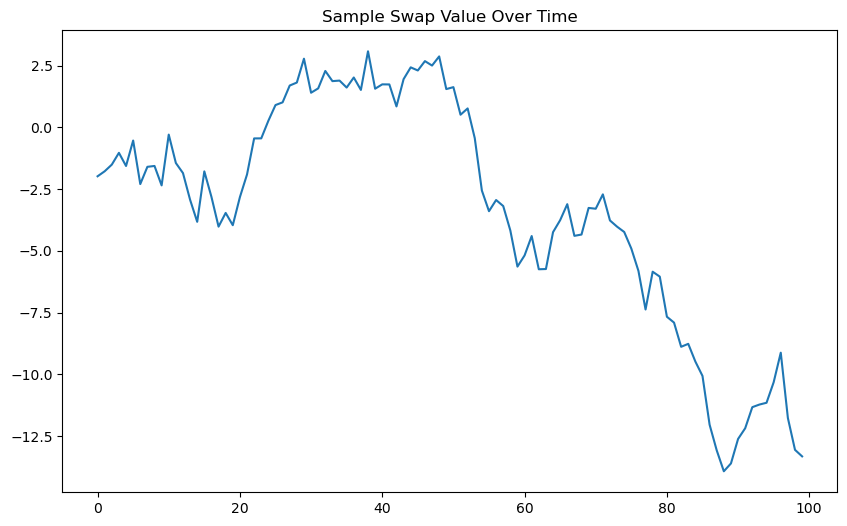

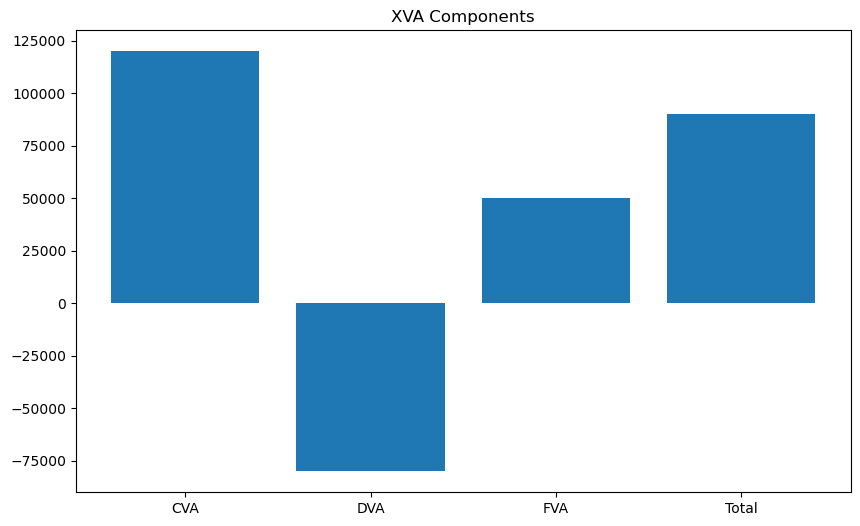

In [7]:
# Example usage 
def main():
    # Import original SwapValuationEngine class
    # This would normally be an import from your module
    # For this example, we'll define a placeholder class
    class SwapValuationEngine:
        pass
    
    # Add visualization methods
    SwapValuationEngine = add_visualization_methods(SwapValuationEngine)
    
    # From here you would use the enhanced class as in the original example
    # For demonstration, we'll show sample plots using mock data
    
    # Create some sample figures
    fig1 = plt.figure(figsize=(10, 6))
    plt.plot(np.random.randn(100).cumsum())
    plt.title('Sample Swap Value Over Time')
    
    fig2 = plt.figure(figsize=(10, 6))
    plt.bar(['CVA', 'DVA', 'FVA', 'Total'], [120000, -80000, 50000, 90000])
    plt.title('XVA Components')
    
    plt.show()

if __name__ == "__main__":
    main()